In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import imp 
import pickle
from IPython.display import clear_output, display

from context import rf_pool
from dataset_func import CrowdedGratings
from rf_pool.utils.functions import gabor_filter

In [36]:
# conv layer params
n_orientations = 8
kernel_size = 5

# dataset params
n = 800
batch_size=10
target_orientations = np.linspace(0, np.pi-(10*np.pi/180), n_orientations)

diameter = 15
input_shape = (25,25)
n_cycles = 5.
contrast = 1
background_size = input_shape[0];
background_value = 127
spacing = None



In [38]:
dataset = CrowdedGratings(n=n, target_orientations=target_orientations, n_flankers=0,
                          diameter=diameter, n_cycles=n_cycles, contrast=contrast,
                          transform=transforms.ToTensor(), background_size=background_size,
                          background_value=background_value, spacing=spacing)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

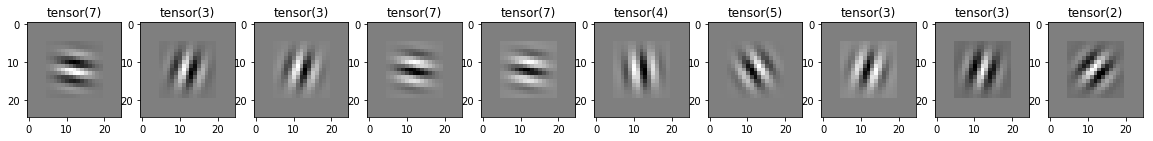

In [39]:
img, l = iter(dataloader).next()
fig,ax = plt.subplots(1,len(l), figsize=(20,4))
for i in range(len(l)):
    ax[i].imshow(img[i,0], "gray", vmin=0,vmax=1)
    ax[i].set_title(l[i])


In [40]:
model = rf_pool.models.Model()
model.add_module('0', rf_pool.modules.FeedForward(
                      hidden=torch.nn.Conv2d(1,32,5),
                      activation=torch.nn.ReLU(),
                      pool = torch.nn.MaxPool2d(2))
                )
model.add_module('1', rf_pool.modules.FeedForward(
                      hidden=torch.nn.Conv2d(32,8,10))
                )


In [42]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=.9)

In [43]:
def validate(model, dataloader):
    with torch.no_grad():
        running_acc = 0
        for i, data in enumerate(dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # forward + backward + optimize
            outputs = torch.flatten(model(inputs), -3, -1)
            running_acc += torch.sum(torch.argmax(outputs,-1) == labels)

    return running_acc / n

In [44]:
n_epochs = 300
for epoch in range(n_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = torch.flatten(model(inputs), -3,-1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    
    if epoch%100 == 99:
        acc = validate(model, dataloader)   
        display("Epoch: {}, Acc: {} Loss: {}".format(epoch, acc, running_loss/ (i+1)))

print('Finished Training')

'Epoch: 99, Acc: 0.9175000190734863 Loss: 0.6722914040088653'

'Epoch: 199, Acc: 1.0 Loss: 0.24073955211788417'

'Epoch: 299, Acc: 1.0 Loss: 0.12498903051018714'

Finished Training


In [ ]:
filename = 'orientation_classifier_weights.pkl'
with open(filename, 'wb') as f:
    pickle.dump(model.state_dict(), f)

## Scratch Work

In [45]:
s = torch.nn.Softmax(1)

In [46]:
crowdset = CrowdedGratings(n=10, target_orientations=target_orientations, n_flankers=9,
                          diameter=diameter, n_cycles=n_cycles, contrast=contrast,
                          transform=transforms.ToTensor(), background_size=60,
                          background_value=background_value, spacing=24)

crowdloader = torch.utils.data.DataLoader(crowdset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

In [47]:
o = torch.tensor(target_orientations*180/np.pi)
o = o.unsqueeze(-1).unsqueeze(-1)
o.shape

torch.Size([8, 1, 1])

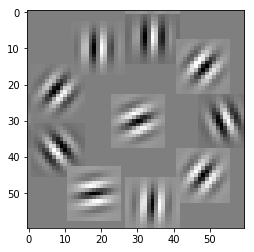

In [54]:
img, l = iter(crowdloader).next()
plt.imshow(img[2,0], "gray")

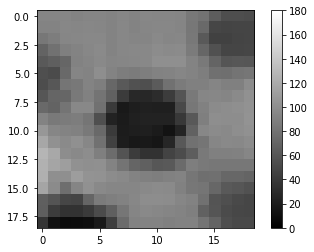

In [56]:
out = torch.sum(s(model(img)) * o, 1) 
plt.imshow(out[2].detach(), "gray", vmin=0,vmax=180)
plt.colorbar()

In [57]:
out.shape

torch.Size([10, 19, 19])